In [2]:
!pip install flair

     |████████████████████████████████| 337kB 4.5MB/s 
     |████████████████████████████████| 276kB 12.9MB/s 
     |████████████████████████████████| 1.1MB 18.3MB/s 
     |████████████████████████████████| 983kB 28.7MB/s 
     |████████████████████████████████| 19.7MB 5.6MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
     |████████████████████████████████| 1.1MB 47.8MB/s 
     |████████████████████████████████| 798kB 43.3MB/s 
     |████████████████████████████████| 890kB 38.7MB/s 
     |████████████████████████████████| 3.0MB 47.4MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=8dd042fc839391cb8fa1d1bcd5a4afbab2b22fa36b20ad7679ce1937d041e947
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
  Created wheel for sqlitedict: filename=sqlitedict-1.7.0-cp36-none-any.whl size=14377 sha256=4fe41e078c53c9e43e0393cd919db03dfc4f05db95e2fe075ac5e35863b33d1b
  Stored in dire

In [9]:
from flair.data import Sentence
from flair.models import SequenceTagger
import flair.datasets
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings, TransformerWordEmbeddings
corpus =  flair.datasets.INSPEC()
import flair, torch
import os
import pandas as pd
from tqdm import tqdm
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

flair.device = torch.device('cuda') 

2020-10-10 18:31:28,154 Reading data from /root/.flair/datasets/inspec
2020-10-10 18:31:28,156 Train: /root/.flair/datasets/inspec/train.txt
2020-10-10 18:31:28,157 Dev: /root/.flair/datasets/inspec/dev.txt
2020-10-10 18:31:28,162 Test: /root/.flair/datasets/inspec/test.txt


In [6]:
# print the number of Sentences in the train split
print(len(corpus.train))

# print the number of Sentences in the test split
print(len(corpus.test))

# print the number of Sentences in the dev split
print(len(corpus.dev))

1000
500
500


In [7]:

# 2. what tag do we want to predict?
tag_type = 'keyword'

# 3. make the tag dictionary from the corpus
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)
print(tag_dictionary)



Dictionary with 8 tags: <unk>, O, B-KEY, E-KEY, S-KEY, I-KEY, <START>, <STOP>


In [10]:
embedding_types = [
    TransformerWordEmbeddings('bert-base-uncased')
]
embeddings: StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)

from flair.models import SequenceTagger

tagger: SequenceTagger = SequenceTagger(hidden_size=256,
                                        embeddings=embeddings,
                                        tag_dictionary=tag_dictionary,
                                        tag_type=tag_type,
                                        use_crf=True)

In [ ]:
# 6. initialize trainer
from flair.trainers import ModelTrainer

trainer: ModelTrainer = ModelTrainer(tagger, corpus)

# 7. start training
trainer.train('resources/taggers/keyphrase',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=150)

In [21]:
model = SequenceTagger.load('resources/taggers/keyphrase/best-model.pt')

# create example sentence
sentence = corpus.test[0].to_tagged_string('text')
print("-------Input sentence------------")
print(sentence)

sentence = Sentence(sentence)
# predict tags and print
model.predict(sentence)
print("--------tag predictions for input sentence----------")
print(sentence.to_tagged_string())

2020-10-10 19:06:32,037 loading file resources/taggers/keyphrase/best-model.pt
-------Input sentence------------
Feedforward maximum power point tracking of PV systems using fuzzy controller A feedforward maximum power -LRB- MP -RRB- point tracking scheme is developed for the interleaved dual boost -LRB- IDB -RRB- converter fed photovoltaic -LRB- PV -RRB- system using fuzzy controller . The tracking algorithm changes the duty ratio of the converter such that the solar cell array -LRB- SCA -RRB- voltage equals the voltage corresponding to the MP point at that solar insolation . This is done by the feedforward loop , which generates an error signal by comparing the instantaneous array voltage and reference voltage . The reference voltage for the feedforward loop , corresponding to the MP point , is obtained by an off-line trained neural network . Experimental data is used for off-line training of the neural network , which employs back-propagation algorithm . The proposed fuzzy feedforwa

Sentence: "Feedforward maximum power point tracking of PV systems using fuzzy controller A feedforward maximum power -LRB- MP -RRB- point tracking scheme is developed for the interleaved dual boost -LRB- IDB -RRB- converter fed photovoltaic -LRB- PV -RRB- system using fuzzy controller . The tracking algorithm changes the duty ratio of the converter such that the solar cell array -LRB- SCA -RRB- voltage equals the voltage corresponding to the MP point at that solar insolation . This is done by the feedforward loop , which generates an error signal by comparing the instantaneous array voltage and reference voltage . The reference voltage for the feedforward loop , corresponding to the MP point , is obtained by an off-line trained neural network . Experimental data is used for off-line training of the neural network , which employs back-propagation algorithm . The proposed fuzzy feedforward peak power tracking effectiveness is demonstrated through the simulation and experimental results ,

2020-10-10 18:45:35,805 ----------------------------------------------------------------------------------------------------
2020-10-10 18:45:35,806 WARNING: No LOSS found for test split in this data.
2020-10-10 18:45:35,808 Are you sure you want to plot LOSS and not another value?
2020-10-10 18:45:35,809 ----------------------------------------------------------------------------------------------------
2020-10-10 18:45:35,838 ----------------------------------------------------------------------------------------------------
2020-10-10 18:45:35,840 WARNING: No F1 found for test split in this data.
2020-10-10 18:45:35,841 Are you sure you want to plot F1 and not another value?
2020-10-10 18:45:35,842 ----------------------------------------------------------------------------------------------------
Loss and F1 plots are saved in resources/taggers/keyphrase/training.png


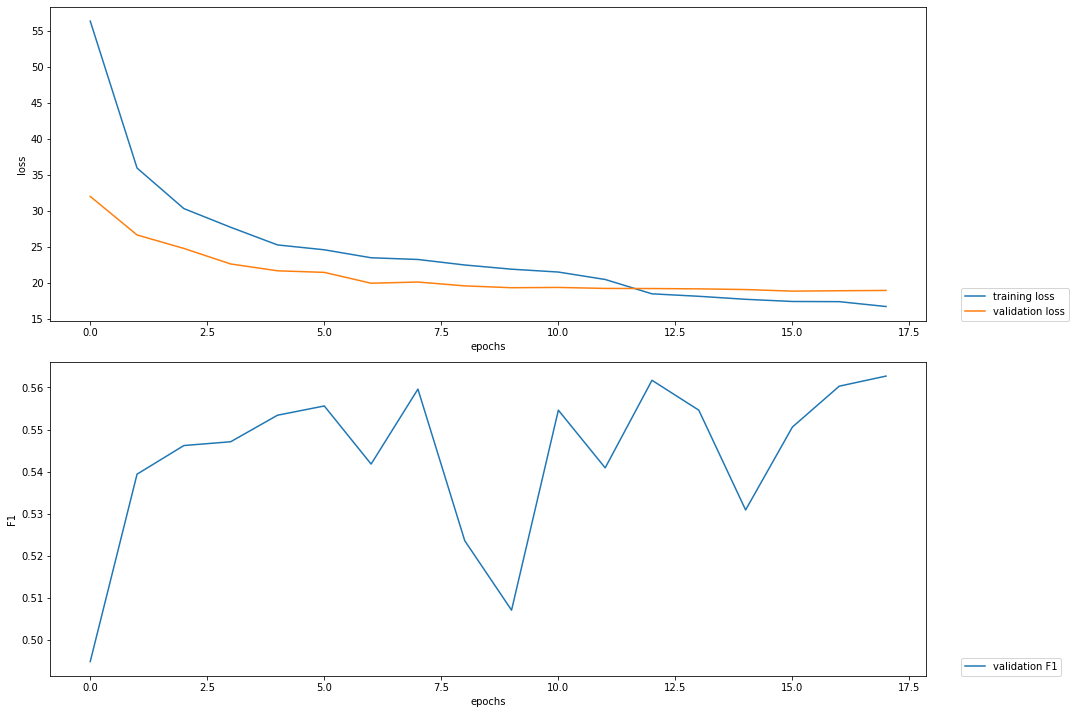

Weights plots are saved in resources/taggers/keyphrase/weights.png


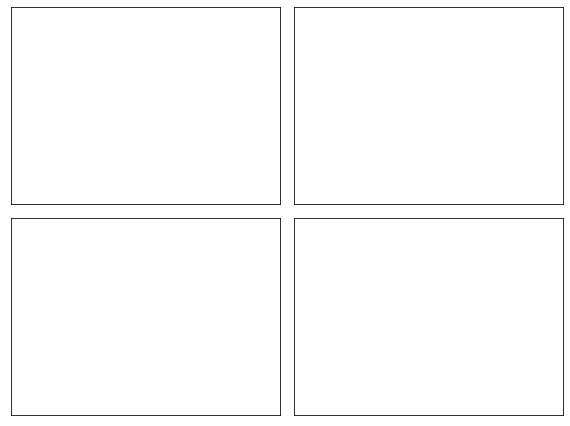

In [17]:
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_training_curves('resources/taggers/keyphrase/loss.tsv')
plotter.plot_weights('resources/taggers/keyphrase/weights.txt')

In [19]:
result, _ = tagger.evaluate(corpus.test)
print(result.detailed_results)


Results:
- F1-score (micro) 0.5066
- F1-score (macro) 0.5066

By class:
KEY        tp: 2180 - fp: 1582 - fn: 2664 - precision: 0.5795 - recall: 0.4500 - f1-score: 0.5066


In [18]:
model = SequenceTagger.load('keyphrase')

# create example sentence
sentence = Sentence('I love Berlin but this has a lot to do with new cities')

# predict tags and print
model.predict(sentence)

print(sentence.to_tagged_string())

2020-10-10 18:46:05,387 loading file keyword


FileNotFoundError: ignored